In [609]:
!pip install pandas

In [610]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [611]:
#Read-in data

data = pd.read_csv("RAOBs_201903131200.txt", delimiter = ',',names = ['Station ID', 'Latitude', 'Longitude', '500-mb Height (m)', '500-mb Wind Direction', '500-mb Wind Speed (kts)'])
df = pd.DataFrame(data)

In [612]:
df

Station ID  Latitude  Longitude  500-mb Height (m)  500-mb Wind Direction  \
0         CWPL     51.47      -90.2             5460.0                  285.0   
1         CWQI     43.83      -66.0             5540.0                  325.0   
2         CWSE     53.55     -113.9             5360.0                  280.0   
3         CYAH     53.75      -73.6             5340.0                  300.0   
4         CYBK     64.30      -96.0             5220.0                   95.0   
..         ...       ...        ...                ...                    ...   
130       KWAL     37.93      -75.4             5730.0                  325.0   
131       KXKF     32.37      -64.6             5620.0                  300.0   
132       KYAK     59.52     -139.6             5340.0                  195.0   
133       KYMW     46.38      -75.9             5580.0                  275.0   
134       KYXY     60.72     -135.0             5340.0                  300.0   

     500-mb Wind Speed (kts)  
0                       29.0  
1                       41.0  
2                       12.0  
3                       70.0  
4                       17.0  
..                       ...  
130                     44.0  
131                     46.0  
132                     22.0  
133                     38.0  
134                     17.0  

[135 rows x 6 columns]

In [613]:
lat_float = df['Latitude'].astype(float)
lon_float = df['Longitude'].astype(float)
obs_ht = df['500-mb Height (m)'].astype(float)
obs_ht = np.array(obs_ht)

In [614]:
#Given Variables

phi_0 = 60                       #Latitude (in degrees)
phi_0_rad = (60/180) * np.pi     #Latitude (in radians)
lam_0 = -115                     #Longitude (in degrees)
lam_0_rad = (-115/180) * np.pi   #Longitude in degrees
e_rad = 637100000                #Radius of Earth (in cm)
map_s = 1/15000000               #Map scale
del_x = 1.27                     #Spacing of points (in cm)
del_y = 1.27                     #Spacing of points (in cm)
x_0 = 18.9                       #(in cm)
y_0 = -6.3                       #(in cm)

#(x_0,y_0) is the northwest corner of the map 

In [615]:
#Create 22x28 grid 

x_values = x_0 + np.arange(22) * del_x            #23 analysis points on the map (x-direction)
y_values = y_0 + np.arange(28) * del_y            #28 analysis points on the map (y-direction)
grid_x, grid_y = np.meshgrid(x_values, y_values)  #Makes the grid

In [616]:
#Convert x,y values from grid into lat,lon. Equations from Appendix A: The Polar Stereographic Map Projection.

grid_lat = (180 / np.pi) * ((np.pi / 2) - (2 * np.arctan(np.sqrt((grid_x / map_s)**2 + (grid_y / map_s)**2) / (e_rad * (1 + np.sin(phi_0_rad))))))  #Latitude 
grid_lon = np.arctan(grid_y / grid_x) * (180 / np.pi) + lam_0                                                                                       #Longitude

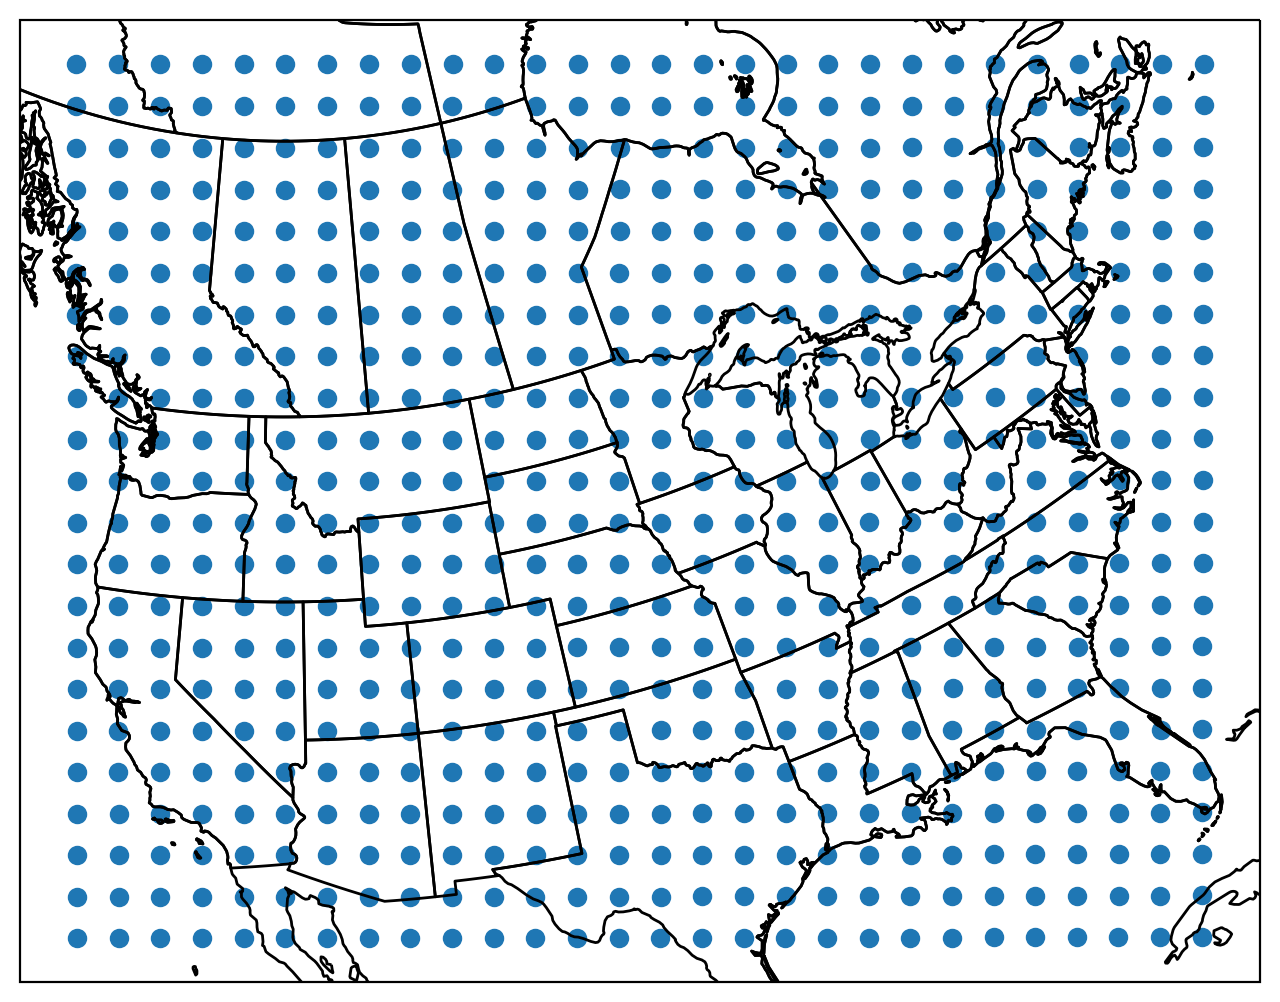

In [617]:
#Create analysis map

proj = ccrs.Stereographic(central_longitude = -115.0, central_latitude = 90.0, true_scale_latitude = 60.0)
fig = plt.figure(figsize = (8,8), dpi = 200)
ax1 = fig.add_subplot(111,projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(grid_lon.ravel(), grid_lat.ravel(), transform = ccrs.PlateCarree())

In [618]:
#Convert obs lat,lon to x,y. Equations from Appendix A: The Polar Stereographic Map Projection

sig = ((1 + np.sin(phi_0_rad)) / (1 + np.sin(lat_float * (np.pi / 180)))) 
obs_x = e_rad * sig * np.cos(lat_float * (np.pi / 180)) * np.cos((lon_float * (np.pi / 180)) - lam_0_rad) * map_s
obs_y = e_rad * sig * np.cos(lat_float * (np.pi / 180)) * np.sin((lon_float * (np.pi / 180)) - lam_0_rad) * map_s

#Make obs x,y into an array

obs_x = np.array(obs_x)
obs_y = np.array(obs_y)

In [619]:
#Convert obs x,y to lat,lon

obs_lat = (180 / np.pi) * ((np.pi / 2) - (2 * np.arctan(np.sqrt((obs_x / map_s)**2 + (obs_y / map_s)**2) / (e_rad * (1 + np.sin(phi_0_rad)))))) 
obs_lon = np.arctan(obs_y / obs_x) * (180 / np.pi) + lam_0

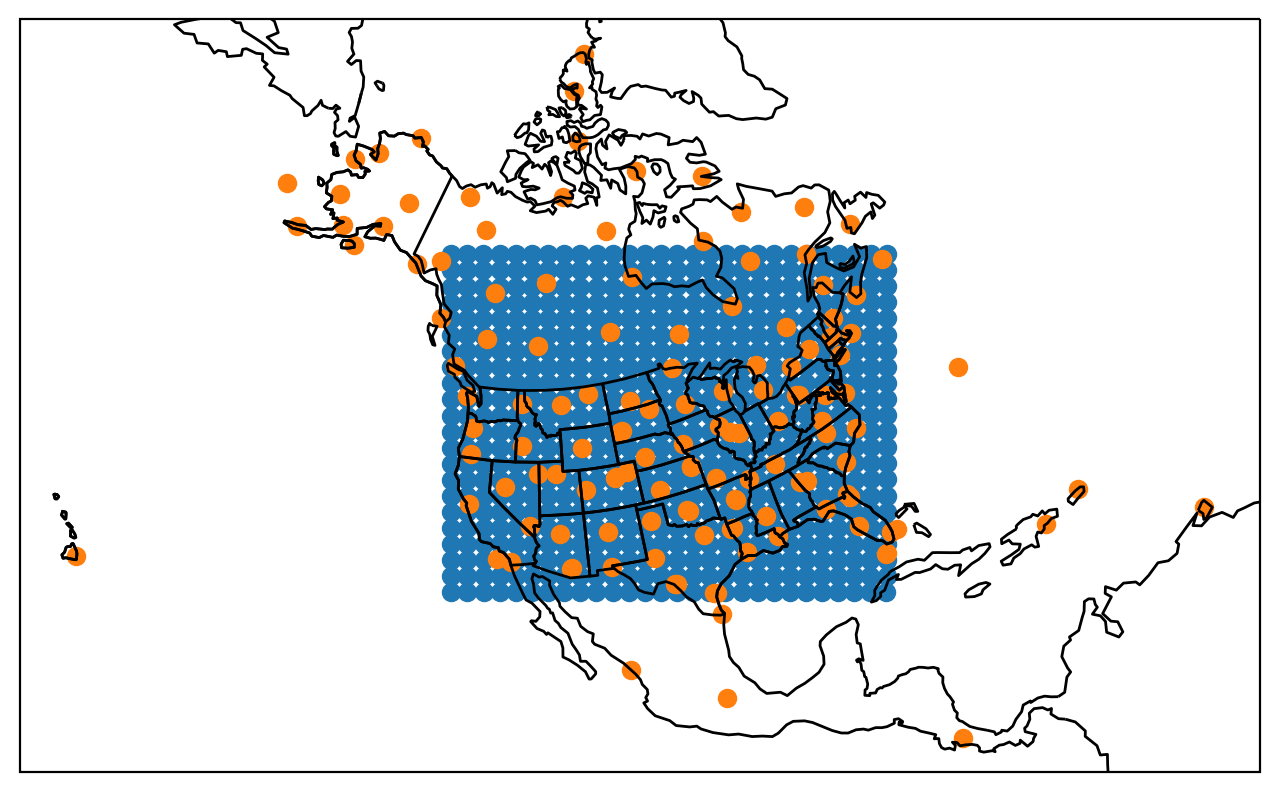

In [620]:
#Plot 500-mb analyses on grid to make sure it is working 

proj = ccrs.Stereographic(central_longitude = -115.0, central_latitude = 90.0, true_scale_latitude = 60.0)
fig = plt.figure(figsize = (8,8), dpi = 200)
ax1 = fig.add_subplot(111,projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(grid_lon.ravel(), grid_lat.ravel(), transform = ccrs.PlateCarree())
ax1.scatter(lon_float,lat_float, transform = ccrs.PlateCarree())

In [621]:
#500mb geopotential height analyses using a second order 2-d polynomial with two radii of influence (10cm and 20cm)

#Radius of influence matrix

ROI_arr = np.array([10,20])

#Empty matrices

x_n = 28                                             #Number of columns
y_n = 22                                             #Number of rows
analysis_matrix = np.empty((x_n,y_n,len(ROI_arr)))
obs_matrix = np.empty((x_n,y_n,len(ROI_arr)))

#Create for loop to fill empty matrices

for i in range(len(ROI_arr)):
    roi = ROI_arr[i]
    for j in range(len(grid_x)):
        for k in range(len(grid_x[0])):
            x_dist = grid_x[j,k] - obs_x
            y_dist = grid_y[j,k] - obs_y
            radius = ((x_dist)**2 + (y_dist)**2)**(1/2)
            index_roi = np.where(radius <= roi)[0]
            
            #Need to make obs_matrix the same dimensions as the index_roi matrix
            
            obs_matrix[j,k,i] = len(index_roi)
            
            #Define the x_k, y_k and f_0 values for the 6x6 matrix
            
            x_k = x_dist[index_roi]
            y_k = y_dist[index_roi]
            f_0 = obs_ht[index_roi]
            
            #Creating the 6x6 analysis matrix (R) and the 6x1 column matrix (O). Need to find C. C = R^-1*O
            
            R_matrix = np.zeros((6,6))
            O_column = np.zeros(6)
            
            #Fill in R matrix and then the O column
            
            for q in range(len(y_k)):
                r_1 = np.matrix([1,x_k[q],y_k[q],x_k[q]**2,y_k[q]**2,x_k[q] * y_k[q]])        #Create 1x6 matrix
                r_1_trans = r_1.T                                                             #Transpose to create 6x1 matrix
                r_2 = r_1_trans * r_1                                                         #Multiply the two together
                R_matrix += np.array(r_2)                                                     
                O_column += np.array([f_0[q],x_k[q] * f_0[q],y_k[q] * f_0[q], x_k[q]**2 * f_0[q],y_k[q]**2 * f_0[q],x_k[q] * y_k[q] * f_0[q]]) 
                
            #Find the average values by dividing by the total number of observations used
            
            R_avg = R_matrix / obs_matrix[j,k,i]
            O_avg = O_column / obs_matrix[j,k,i]
            
            #Now, create the C column
            
            C = np.linalg.inv(np.matrix(R_avg)) * np.matrix(O_avg).T
            
            #Fill in analysis matrix
            
            analysis_matrix[j,k,i] = C[0,0]

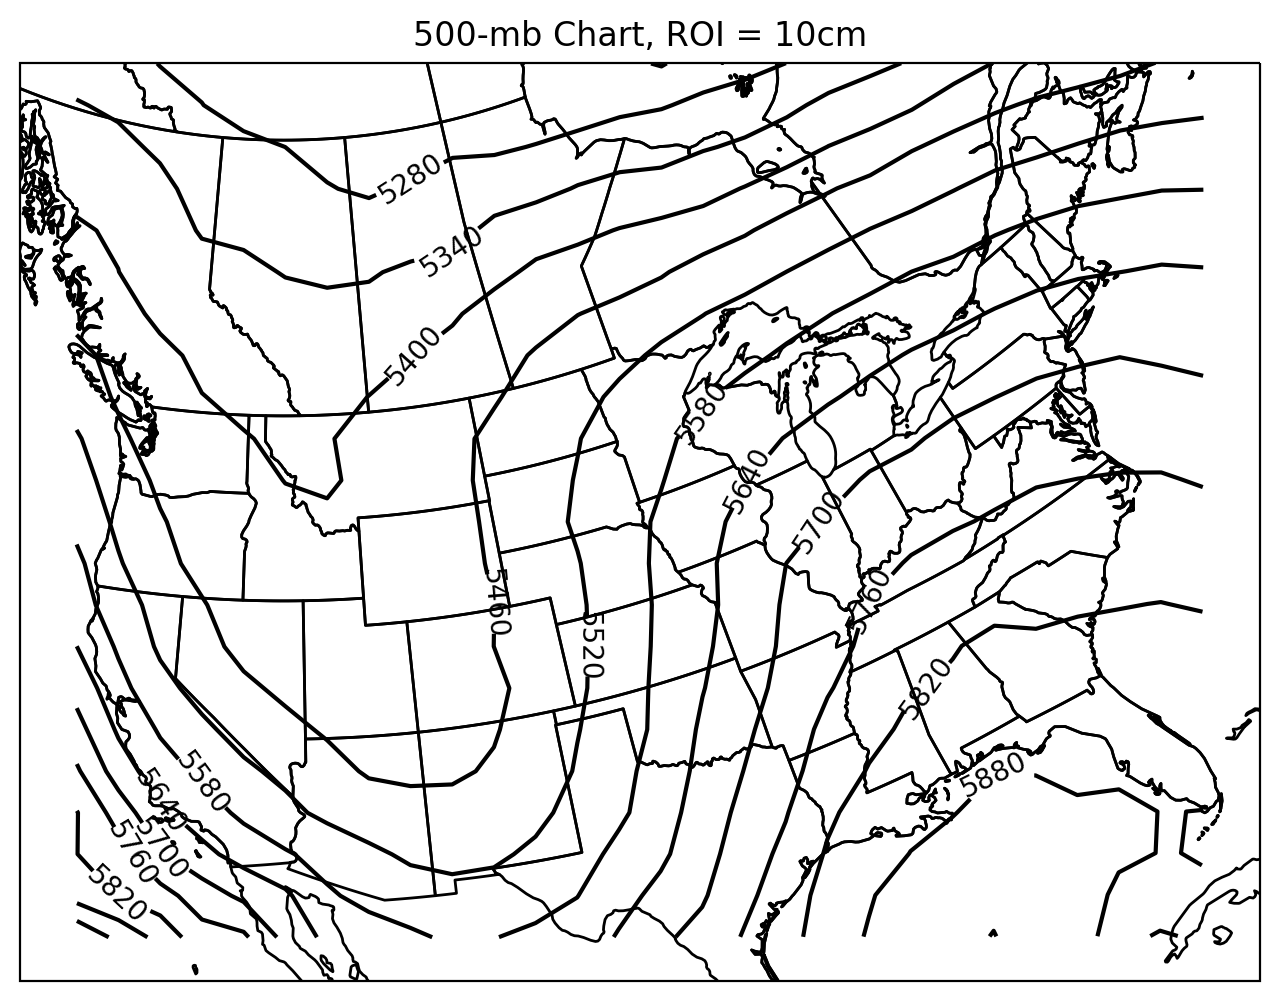

In [622]:
#500-mb contour chart, ROI = 10cm

proj = ccrs.Stereographic(central_longitude = -115.0, central_latitude = 90.0, true_scale_latitude = 60.0)
fig = plt.figure(figsize = (8,8), dpi = 200)
ax1 = fig.add_subplot(111,projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(grid_lon,grid_lat,analysis_matrix[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('500-mb Chart, ROI = 10cm')
plt.savefig("500-mb Chart, ROI = 10cm")
plt.show()

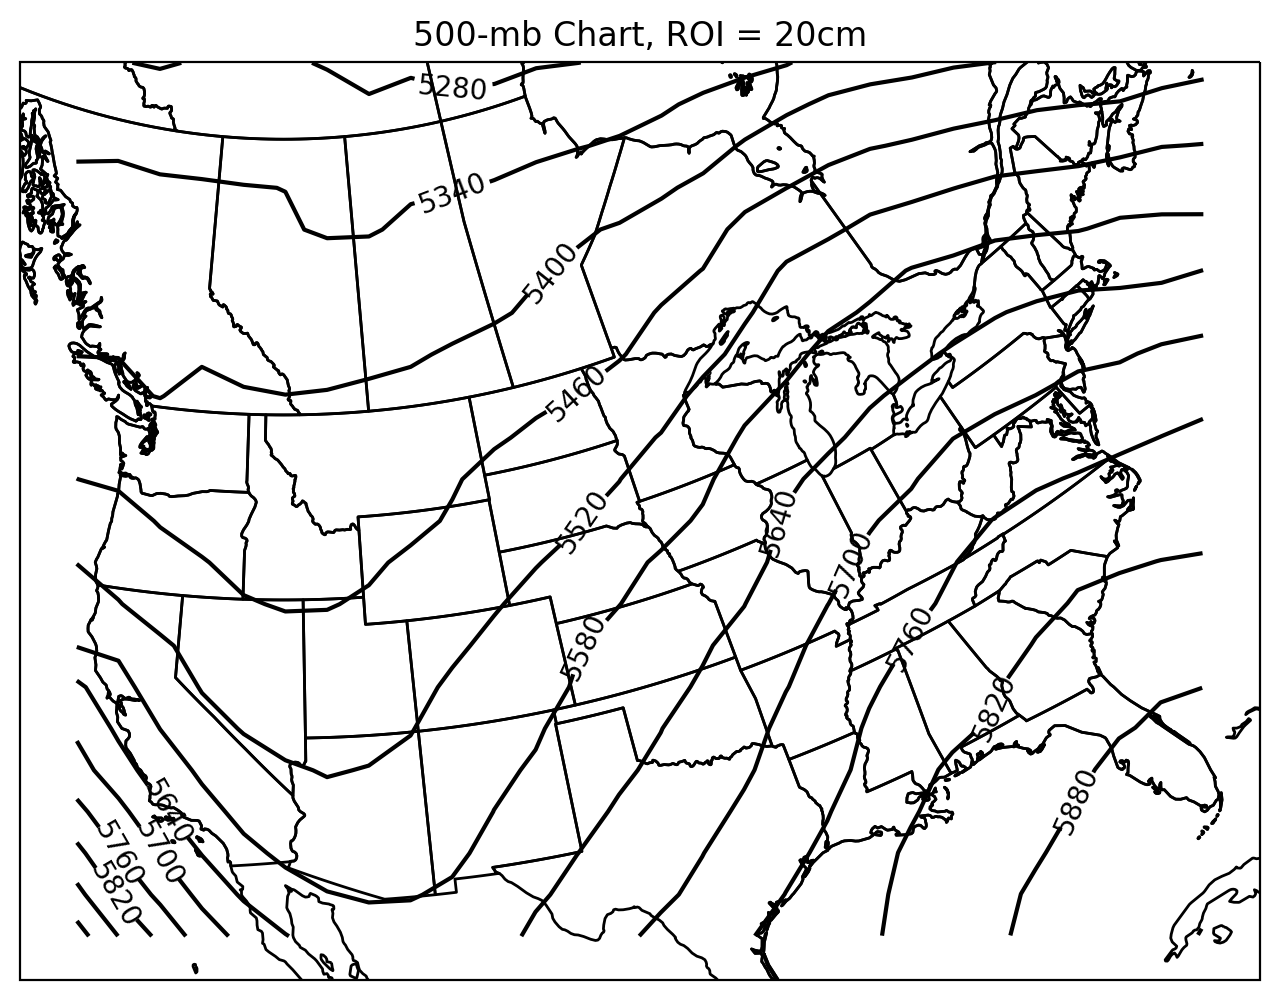

In [623]:
#500-mb contour chart, ROI = 20cm

proj = ccrs.Stereographic(central_longitude = -115.0, central_latitude = 90.0, true_scale_latitude = 60.0)
fig = plt.figure(figsize = (8,8), dpi = 200)
ax1 = fig.add_subplot(111,projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(grid_lon,grid_lat,analysis_matrix[:,:,1],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('500-mb Chart, ROI = 20cm')
plt.savefig("500-mb Chart, ROI = 20cm")
plt.show()

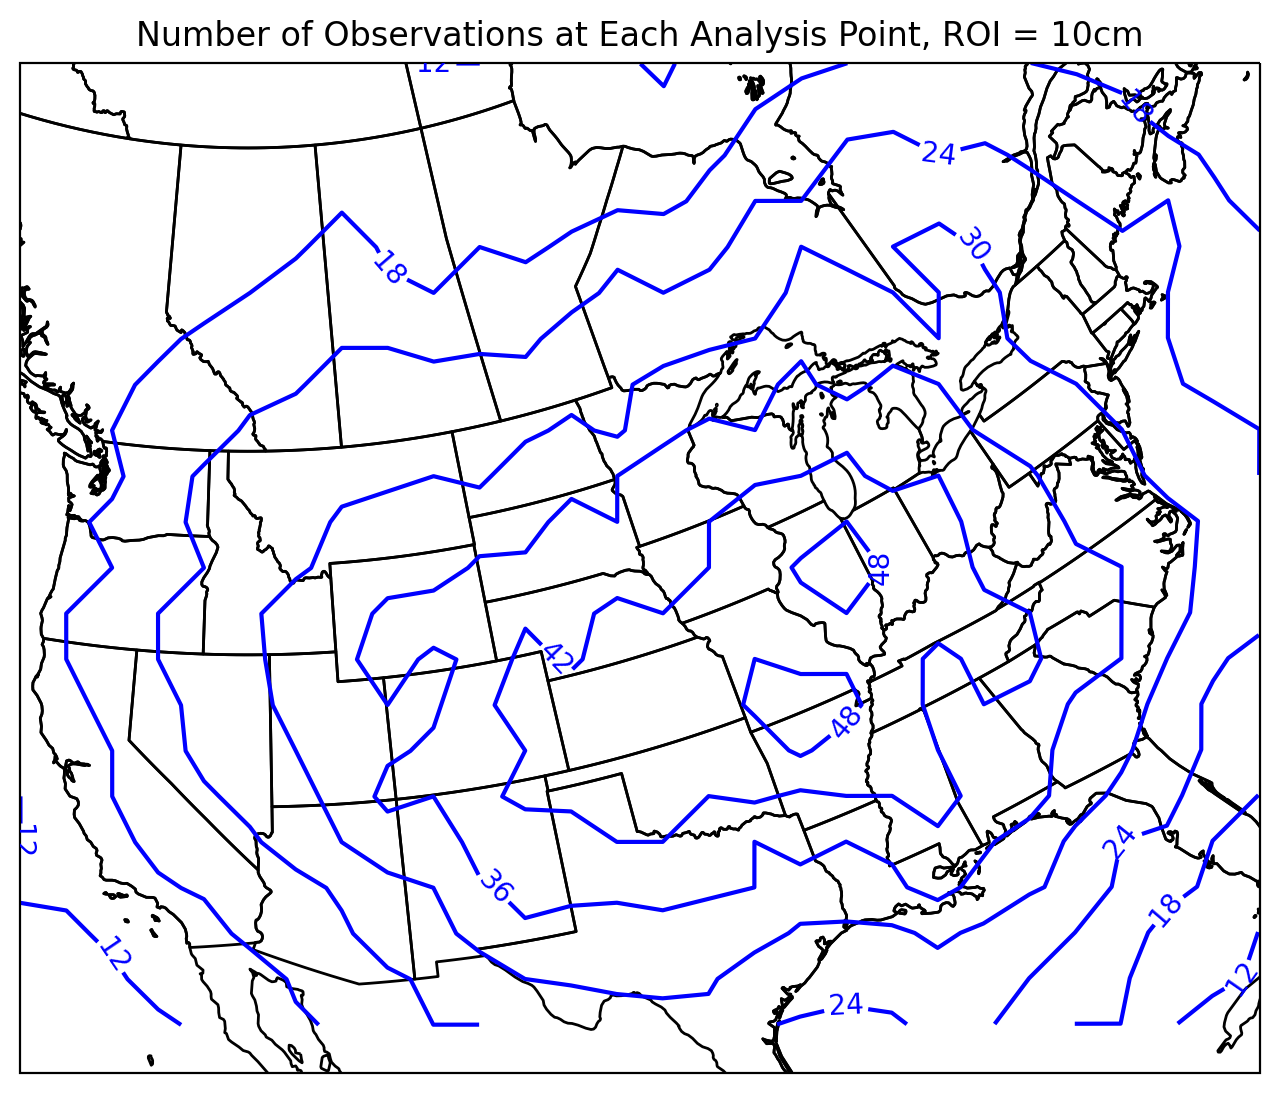

In [624]:
#Chart showing the number of observations at each analysis point, ROI = 10cm

proj = ccrs.Stereographic(central_longitude = -115.0, central_latitude = 90.0, true_scale_latitude = 60.0)
fig = plt.figure(figsize = (8,8), dpi = 200)
ax1 = fig.add_subplot(111,projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(grid_lon,grid_lat,obs_matrix[:,:,0],colors='b',transform=ccrs.PlateCarree())
plt.clabel(cs1)
plt.title('Number of Observations at Each Analysis Point, ROI = 10cm')
plt.savefig("Number of Observations at Each Analysis Point, ROI = 10cm")
plt.show()

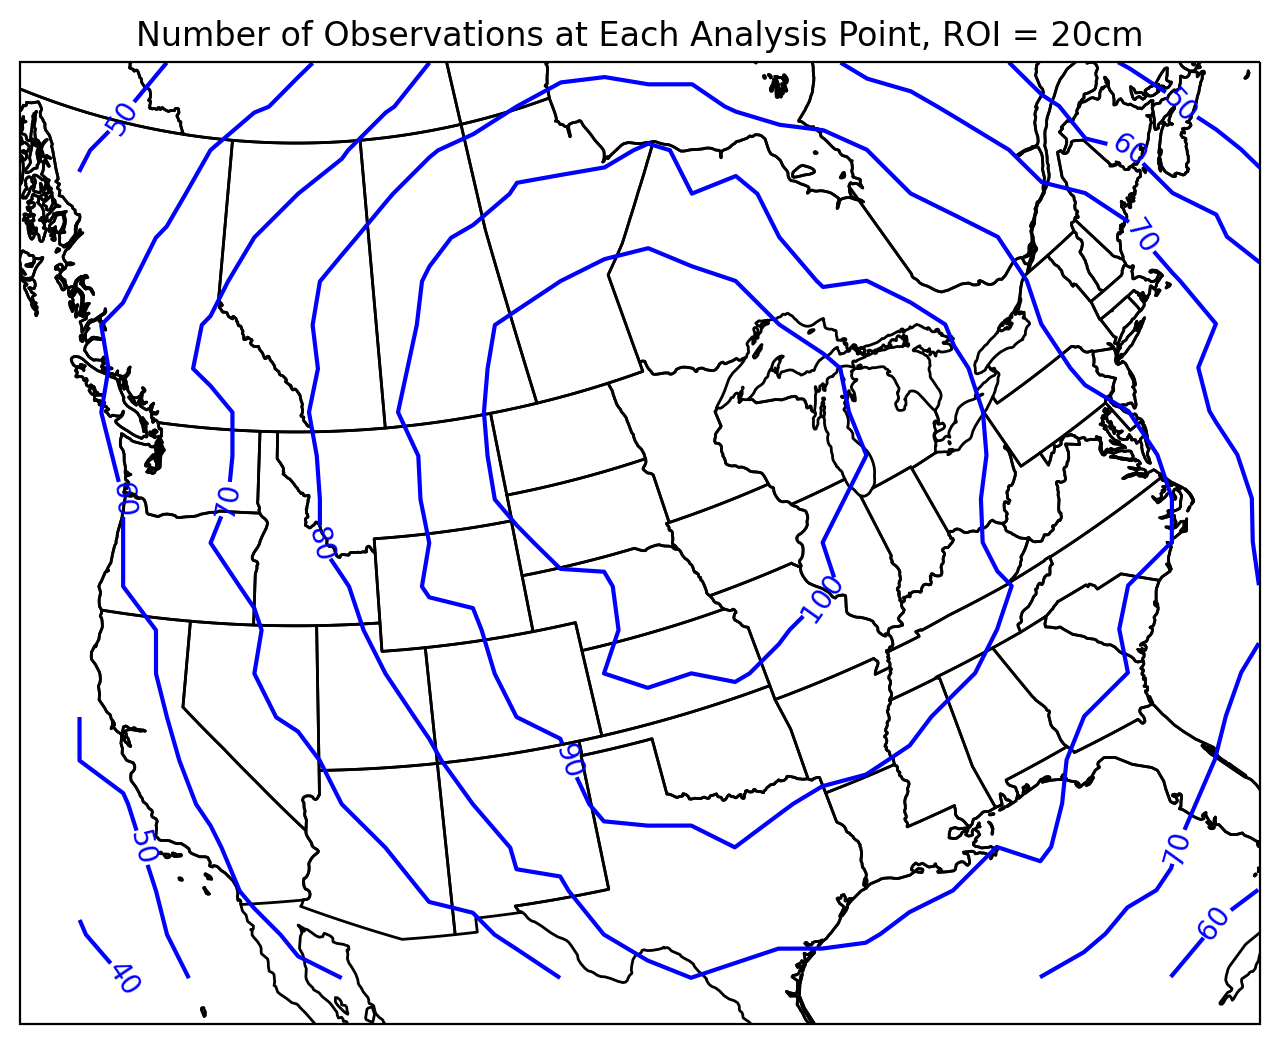

In [625]:
#Chart showing the number of observations at each analysis point, ROI = 20cm

proj = ccrs.Stereographic(central_longitude = -115.0, central_latitude = 90.0, true_scale_latitude = 60.0)
fig = plt.figure(figsize = (8,8), dpi = 200)
ax1 = fig.add_subplot(111,projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(grid_lon,grid_lat,obs_matrix[:,:,1],colors='b',transform=ccrs.PlateCarree())
plt.clabel(cs1)
plt.title('Number of Observations at Each Analysis Point, ROI = 20cm')
plt.savefig("Number of Observations at Each Analysis Point, ROI = 20cm")
plt.show()

In [626]:
#Store number of analysis values in text file

a_file = open("Analysis_Matrix_ROI_10", "w")
for line in analysis_matrix[:,:,0]:
    np.savetxt(a_file, line)
    
b_file = open("Analysis_Matrix_ROI_20", "w")
for line in analysis_matrix[:,:,1]:
    np.savetxt(b_file, line) 

In [627]:
#Store number of observations available at each grid point in text file

c_file = open("Observation_Matrix_ROI_10", "w")
for line in obs_matrix[:,:,0]:
    np.savetxt(c_file, line)
    
d_file = open("Observation_Matrix_ROI_20", "w")
for line in obs_matrix[:,:,1]:
    np.savetxt(d_file, line)